In [1]:
import abc
from IPython.display import Image
from anytree import Node as AnyTreeNode
from anytree.exporter import DotExporter as AnyTreeExporter

In [2]:

class Node(abc.ABC):
    def __init__(self, name):
        self.name = name
        self.highlight = False
        self.relation = 'OR'
        self.children = []
    def add(self, node):
        self.children.append(node)
        return self

class Resource(Node):
    def __init__(self, name):
        super().__init__(name)
        self.shape = 'box'
        self.color = 'black'
        self.type = 'resource'
    def all_necessary(self):
        self.relation = 'AND'
        return self

class Defense(Node):
    def __init__(self, name, cost):
        self.shape = 'ellipse'
        self.color = 'blue'
        self.type = 'defense'
        self.cost = cost
        super().__init__(name)
    def __repr__(self):
        return "Defense: {} - {}".format(self.name, self.cost)

class Attack(Node):
    def __init__(self, name):
        super().__init__(name)
        self.color = 'red'
        self.shape = 'box'
        self.type = 'attack'

class Method(Node):
    def __init__(self, name):
        super().__init__(name)
        self.shape = 'box'
        self.color = 'green'
        self.type = 'method'
    def all_necessary(self):
        self.relation = 'AND'
        return self


In [3]:
r = Resource('Bank Account').add(
        Method("ATM").add(
            Method("Pin").add(
                Attack("Eavesdropping").add(
                    Defense("Periodic Inspection", 2)
                )
            ).add(
                Attack("Find Note").add(
                    Defense("Memorization", 1)
                )
            )
        ).add(
            Attack("Card").add(
                Defense("Report Loss", 1)
            )
        ).add(
            Defense("Face Recognition", 2)
        ).all_necessary()
    ).add(
        Method("Online").add(
            Method("Password").add(
                Attack("Phishing").add(
                    Defense("Server Side Filtering", 2)
                )
            ).add(
                Attack("Keylogger").add(
                    Defense("Antivirus Software", 2)
                )
            ).add(
                Defense("Two Factor Authentication", 1)
            )
        ).add(
            Attack("Username")
        ).all_necessary()
    )


In [4]:
def set_color_shape(node):
    attrs = []
    attrs += [f'color={node.color}'] if hasattr(node, 'color') else []
    attrs += [f'shape={node.shape}'] if hasattr(node, 'shape') else []
    return ', '.join(attrs)


def generate_graph(node, parent = None):
    if parent is None:
        tmp = AnyTreeNode(node.name + " - " + node.relation, shape=node.shape, color=node.color)
    elif node.type == 'defense':
        tmp = AnyTreeNode("%s - %s" % (node.name, node.cost), parent = parent, shape=node.shape, color=node.color)
    else:
        tmp = AnyTreeNode(node.name + " - " + node.relation, parent = parent, shape=node.shape, color=node.color)
    for child in node.children:
        generate_graph(child, parent = tmp)
    return tmp



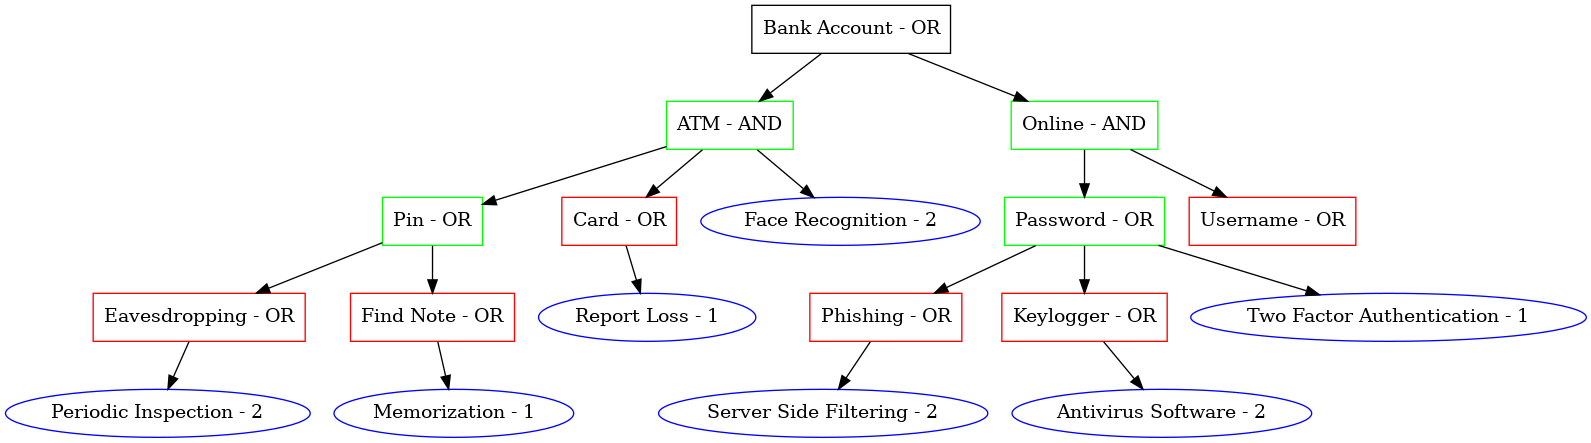

In [5]:
AnyTreeExporter(generate_graph(r), nodeattrfunc=set_color_shape).to_picture("adtree.png")
Image(filename = 'adtree.png')

In [6]:
class AND:
    def __new__(cls, *elements):
        if len(elements) == 0:
            return None
        if any(e is False for e in elements):
            return False
        if all(e is None for e in elements):
            return None
        if all(e is True or e is None for e in elements):
            return True
        return super().__new__(cls)
    def __init__(self, *elements):
        self.elements = []
        for e in elements:
            if e is True or e is None:
                continue
            if isinstance(e, self.__class__):
                self.elements += e.elements
            else:
                self.elements.append(e)
    def __repr__(self):
        return "AND:[" + ",".join(repr(i) for i in self.elements) + "]"
    def __iter__(self):
        return iter(self.elements)

class OR:
    def __new__(cls, *elements):
        if len(elements) == 0:
            return None
        if any(e is True for e in elements):
            return True
        if all(e is None for e in elements):
            return None
        if all(e is False or e is None for e in elements):
            return False
        return super().__new__(cls)
    def __init__(self, *elements):
        self.elements = []
        for e in elements:
            if e is False or e is None:
                continue
            if isinstance(e, self.__class__):
                self.elements += e.elements
            else:
                self.elements.append(e)
    def __repr__(self):
        return "OR:[" + ", ".join(repr(i) for i in self.elements) + "]"
    def __iter__(self):
        return iter(self.elements)

In [7]:
def generate_boolean_expression(root):
    defense_expression = False
    child_expressions = []
    for node in root.children:
        if node.type != 'defense':
            child_expressions.append(generate_boolean_expression(node))
        else:
            defense_expression = node
    if root.relation == 'OR':
        return OR(defense_expression, AND(*child_expressions))
    else:
        return OR(defense_expression, OR(*child_expressions))

In [8]:
import itertools
def convert_to_disjunctive_normal_form(expression):
    if not isinstance(expression, (OR, AND)):
        result = OR(AND(expression))
    elif isinstance(expression, OR):
        result = OR(*[se for e in expression for se in convert_to_disjunctive_normal_form(e)])
    elif isinstance(expression, AND):
        total = []
        for c in itertools.product(*[convert_to_disjunctive_normal_form(e) for e in expression]):
            total.append(AND(*[se for e in c for se in e]))
        result = OR(*total)
    return result

In [9]:
def generate_path_sets(dnf):
    result = []
    assert(isinstance(dnf, OR))
    for exp in dnf:
        assert(isinstance(exp, AND))
        assert(all(isinstance(e, Defense) for e in exp))
        result.append(set(exp.elements))
    return result


In [10]:
def calculate_path_set_cost(pathset):
    total_cost = 0
    for pathset_node in pathset:
        if pathset_node.type == 'defense':
            total_cost += pathset_node.cost
        else:
            assert(False)
    return total_cost

In [11]:
def pathset_min_cost(pathsets):
    cost = float('inf')
    min_cost_path_set = None
    for pathset in pathsets:
        val = calculate_path_set_cost(pathset)
        if val < cost:
            cost = val
            min_cost_path_set = pathset
    return min_cost_path_set, cost

In [12]:
boolean_exp = generate_boolean_expression(r)
boolean_exp

OR:[AND:[OR:[Defense: Face Recognition - 2, AND:[OR:[Defense: Periodic Inspection - 2],OR:[Defense: Memorization - 1]], Defense: Report Loss - 1],OR:[Defense: Two Factor Authentication - 1, AND:[OR:[Defense: Server Side Filtering - 2],OR:[Defense: Antivirus Software - 2]]]]]

In [13]:
dnf = convert_to_disjunctive_normal_form(boolean_exp)
dnf

OR:[AND:[Defense: Face Recognition - 2,Defense: Two Factor Authentication - 1], AND:[Defense: Face Recognition - 2,Defense: Server Side Filtering - 2,Defense: Antivirus Software - 2], AND:[Defense: Periodic Inspection - 2,Defense: Memorization - 1,Defense: Two Factor Authentication - 1], AND:[Defense: Periodic Inspection - 2,Defense: Memorization - 1,Defense: Server Side Filtering - 2,Defense: Antivirus Software - 2], AND:[Defense: Report Loss - 1,Defense: Two Factor Authentication - 1], AND:[Defense: Report Loss - 1,Defense: Server Side Filtering - 2,Defense: Antivirus Software - 2]]

In [14]:
ps = generate_path_sets(dnf)
for p in ps:
    print(p, calculate_path_set_cost(p))

{Defense: Face Recognition - 2, Defense: Two Factor Authentication - 1} 3
{Defense: Antivirus Software - 2, Defense: Face Recognition - 2, Defense: Server Side Filtering - 2} 6
{Defense: Memorization - 1, Defense: Two Factor Authentication - 1, Defense: Periodic Inspection - 2} 4
{Defense: Memorization - 1, Defense: Antivirus Software - 2, Defense: Server Side Filtering - 2, Defense: Periodic Inspection - 2} 7
{Defense: Two Factor Authentication - 1, Defense: Report Loss - 1} 2
{Defense: Server Side Filtering - 2, Defense: Antivirus Software - 2, Defense: Report Loss - 1} 5


In [15]:
min_cost_path_set, cost = pathset_min_cost(ps)

In [16]:
min_cost_path_set

{Defense: Report Loss - 1, Defense: Two Factor Authentication - 1}

In [17]:
cost

2